In [4]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-17475098-841e-180f-4a25-fd66e3ef53c9)


In [5]:
import torch
import numpy as np
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
# from tasks.mm_tasks.refcoco import RefcocoTask
from tasks.cv_tasks.localization import LocalizationTask

from PIL import Image

tasks.register_task('localization', LocalizationTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = True

img_size=256
model_size="tiny"
# specify some options for evaluation
parser = options.get_generation_parser()
# input_args = ["", "--task=localization", "--beam=10", f"--path=run_scripts/deepfashion/checkpoints/loc/{model_size}/30_1000_5e-5_{img_size}/checkpoint_best.pt", "--bpe-dir=utils/BPE", "--no-repeat-ngram-size=3", f"--patch-image-size={img_size}"]
input_args = ["", "--task=localization", "--beam=10", f"--path=checkpoints/ofa_{model_size}.pt", "--bpe-dir=utils/BPE", "--no-repeat-ngram-size=3", f"--patch-image-size={img_size}"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

In [6]:
# configファイルと学習済みモデルのロード
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task
)
print(len(models))

# GPUに載せる
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# generatorの初期化
generator = task.build_generator(models, cfg.generation)

2024-01-23 08:30:45 | INFO | tasks.ofa_task | source dictionary: 59457 types
2024-01-23 08:30:45 | INFO | tasks.ofa_task | target dictionary: 59457 types


1


In [7]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}")
print(f"Trainable params: {trainable_params}")

Total params: 33488336
Trainable params: 33488336


In [8]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((task.cfg.patch_image_size, task.cfg.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()


def get_symbols_to_strip_from_output(generator):
    if hasattr(generator, "symbols_to_strip_from_output"):
        return generator.symbols_to_strip_from_output
    else:
        return {generator.bos, generator.eos}


def decode_fn(x, tgt_dict, bpe, generator, tokenizer=None):
    x = tgt_dict.string(x.int().cpu(), extra_symbols_to_ignore=get_symbols_to_strip_from_output(generator))
    token_result = []
    bin_result = []
    img_result = []
    for token in x.strip().split():
      if token.startswith('<bin_'):
        bin_result.append(token)
      elif token.startswith('<code_'):
        img_result.append(token)
      else:
        if bpe is not None:
          token = bpe.decode('{}'.format(token))
        if tokenizer is not None:
          token = tokenizer.decode(token)
        if token.startswith(' ') or len(token_result) == 0:
          token_result.append(token.strip())
        else:
          token_result[-1] += token

    return ' '.join(token_result), ' '.join(bin_result), ' '.join(img_result)


def coord2bin(coords, w_resize_ratio, h_resize_ratio):
    coord_list = [float(coord) for coord in coords.strip().split()]
    bin_list = []
    bin_list += ["<bin_{}>".format(int((coord_list[0] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[1] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[2] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int((coord_list[3] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    return ' '.join(bin_list)


def bin2coord(bins, w_resize_ratio, h_resize_ratio):
    bin_list = [int(bin[5:-1]) for bin in bins.strip().split()]
    coord_list = []
    coord_list += [bin_list[0] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[1] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    coord_list += [bin_list[2] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[3] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    return coord_list


def encode_text(text, length=None, append_bos=False, append_eos=False):
    line = [
      task.bpe.encode(' {}'.format(word.strip()))  # 下の条件以外を単語ごとにencodeして数字にし、配列にぶち込む
      # BPE: Byte Pair Encodingの頭文字であり、文書における低頻度の単語をさらに分割することで、低頻度の単語もうまく扱えるようにする手法
      if not word.startswith('<code_') and not word.startswith('<bin_') else word # <code_ と <bin_ はそのまま通す
      for word in text.strip().split() # 両端の空白を削除し、空白で分割（単語に）
    ]

    line = ' '.join(line) # 配列をつなげる
    s = task.tgt_dict.encode_line( # fairseq/data/dictionary.py
        line=line,
        add_if_not_exist=False,
        append_eos=False
    ).long() # タスクごとに文章をエンコード　数値が変わっている　トークン化？
    
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s]) # スタート[0]をつける
    if append_eos:
        s = torch.cat([s, eos_item]) # エンド[2]をつける
    return s

def construct_sample(image: Image, instruction: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    instruction = encode_text(' {}'.format(instruction.lower().strip()), append_bos=True, append_eos=True).unsqueeze(0) # lower()で全て小文字にし、strip()で両端の空白を削除→encode_textで文字をベクトルにエンコード
    instruction_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in instruction])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": instruction,
            "src_lengths": instruction_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        }
    }
    return sample
  
def apply_half(t): # Function to turn FP32 to FP16
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/opt/conda/envs/ofa/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [9]:
import matplotlib.pyplot as plt

In [10]:
import os
offset = 0
file_dir = "/local/DeepFashion2/"
phase = "validation"
fp = open(os.path.join(file_dir,'ofa',f"{phase}_loc_all.tsv"), "r")
lineid_to_offset = []
for line in fp:
    lineid_to_offset.append(offset)
    offset += len(line.encode('utf-8'))

In [11]:
with open('/data01/DeepFashion2/category.tsv', 'r') as f:
    tmp = f.read().splitlines()
classes = {t.split('\t')[0]: t.split('\t')[1] for t in tmp}
classes

{'1': 'short_sleeved_shirt',
 '2': 'long_sleeved_shirt',
 '3': 'short_sleeved_outwear',
 '4': 'long_sleeved_outwear',
 '5': 'vest',
 '6': 'sling',
 '7': 'shorts',
 '8': 'trousers',
 '9': 'skirt',
 '10': 'short_sleeved_dress',
 '11': 'long_sleeved_dress',
 '12': 'vest_dress',
 '13': 'sling_dress'}

In [12]:
from PIL import ImageDraw
from utils.loc_score import loc_metric

def Loc(img_number=0, save_dir=False, is_print=True):
    fp.seek(lineid_to_offset[img_number])
    image_id, image_path, obj_name, label = fp.readline().rstrip("\n").split("\t")
    if is_print:
        print(image_id)
    image_path = os.path.join(file_dir, phase, image_path)
    image = Image.open(image_path).convert("RGB")
    w, h = image.size
    w_resize_ratio = task.cfg.patch_image_size / w
    h_resize_ratio = task.cfg.patch_image_size / h

    boxes_target = {"obj_boxes": [], "obj_ids": [], "objs": [], "size": torch.tensor([h, w])}
    label_list = label.strip().split('&&')
    for label in label_list:
        obj_x0, obj_y0, obj_x1, obj_y1 = label.strip().split(',')
        boxes_target["obj_boxes"].append([float(obj_x0), float(obj_y0), float(obj_x1), float(obj_y1)])
    if is_print:
        img_gt = image.copy()
        draw = ImageDraw.Draw(img_gt)
        # img = cv2.resize(img, (task.cfg.patch_image_size, task.cfg.patch_image_size))
        for i, (obj_box) in enumerate(boxes_target["obj_boxes"]):
            print(f'GT: {obj_box}')
            draw.rectangle([(obj_box[0], obj_box[1]), (obj_box[2], obj_box[3])], outline=(0, 255, 0), width=3)

    obj = " ".join(["<bin_{}>".format(int(pos)) for pos in boxes_target["obj_boxes"][0][:4]])
    instruction = f' which region does the text " {obj_name} " describe?'
    if is_print:
        print(instruction)
    sample = construct_sample(image, instruction)
    sample = utils.move_to_cuda(sample) if use_cuda else sample
    sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

    # Generate result
    with torch.no_grad():
        hypos = task.inference_step(generator, models, sample)
        # print(hypos[0][0]["tokens"])
        tokens, bins, imgs = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
        
    if bins != '':
        cut_bins = bin2coord(bins, w_resize_ratio, h_resize_ratio)
        cut_bins = np.array(cut_bins).reshape(-1, 4)
        if is_print:
            print(cut_bins.shape)
            for bin in cut_bins:
                draw.rectangle([(bin[0], bin[1]), (bin[2], bin[3])], outline=(255, 0, 0), width=3)
    if is_print:
        if bins != '':
            print(f'Pred: {cut_bins}')
        else:
            print(f'Pred: {tokens}')
        if save_dir:
            fig = plt.figure(figsize=(20,10))
            plt.subplot(121)
            plt.imshow(image)
            plt.title('Origin')
            plt.axis('off')
            plt.subplot(122)
            plt.imshow(img_gt)
            plt.title('Ground_Truth')
            plt.axis('off')
            plt.savefig(f'results/{save_dir}/{image_id}.png')
        else:
            # display(image)
            display(img_gt)
            # plt.show()
    score = loc_metric(cut_bins.tolist(), boxes_target["obj_boxes"])
    return score


51684
GT: [309.0, 134.0, 450.0, 299.0]
GT: [451.0, 139.0, 595.0, 304.0]
 which region does the text " short_sleeved_shirt " describe?
(1, 4)
Pred: [[310.07007007  68.54054054 458.05805806 566.09409409]]


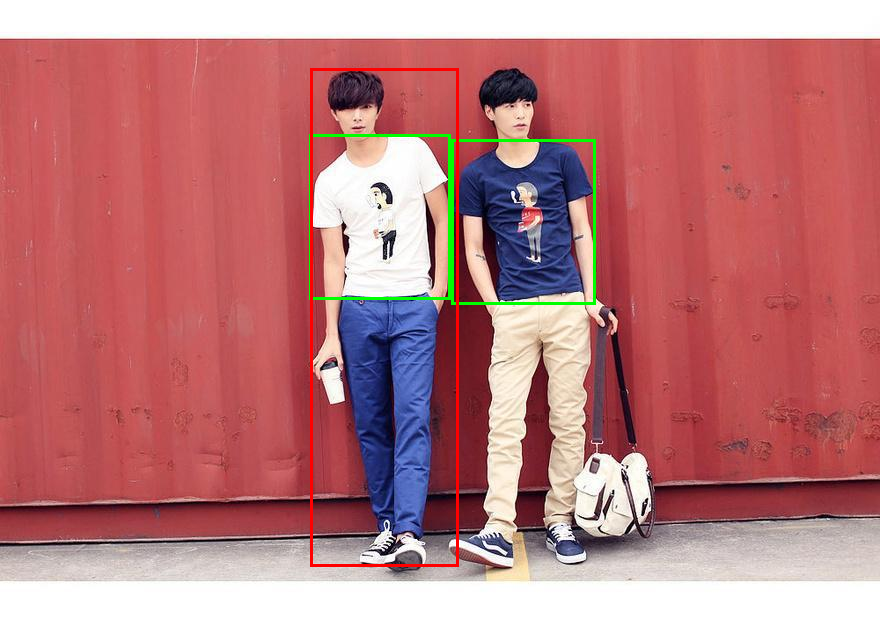

0.1564076972054529

In [13]:
Loc(51683, is_print=True)

In [15]:
from tqdm import tqdm
scores = []
for i in tqdm(range(len(lineid_to_offset))):
    score = Loc(i, is_print=False)
    scores.append(score)
np.mean(scores)

100%|██████████| 51960/51960 [34:31<00:00, 25.09it/s]


0.4438813724176236